In [1]:
import pandas as pd
import numpy as np
import joblib



In [2]:
df = pd.read_csv('../data/cleaned_dataset.csv',index_col=0)
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city)
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari
2,San Churro Cafe,1,0,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari
3,Addhuri Udupi Bhojana,0,0,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari
4,Grand Village,0,0,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari


In [5]:
df.nunique()

name                            6602
online_order                       2
book_table                         2
rate                              31
votes                           2323
location                          92
rest_type                         87
cuisines                        2367
approx_cost(for two people)       63
reviews_list                   21103
listed_in(type)                    7
listed_in(city)                   30
dtype: int64

In [6]:
df['cuisines'] = df['cuisines'].apply(lambda x: x.lower())

In [7]:
m = ",".join(df['cuisines'].to_list())

In [8]:
df['cuisines'] = df['cuisines'].apply(lambda x: x.replace(' ',''))

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
from preprocessor import features_to_drop,sklearnTransformerWrapper,sklearnCountVector

CountVectorizer()

sklearnCountVector(variable=['cuisines'])

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [77]:

class sklearnCountVector(BaseEstimator, TransformerMixin):

    def __init__(self, variable=None):

        self.variable = variable[0]
        

        self.transformer = CountVectorizer()

    def fit(self, X, y=None):
        
        X = X.copy()
        X[self.variable] = X[self.variable].apply(lambda x: x.lower())
        X[self.variable] = X[self.variable].apply(lambda x: x.replace(' ',''))
        self.transformer.fit(X[self.variable])
        return self

    def transform(self, X):
        
        X = X.copy()
        X[self.variable] = X[self.variable].apply(lambda x: x.lower())
        X[self.variable] = X[self.variable].apply(lambda x: x.replace(' ',''))
        x = X[self.variable]

        xx = self.transformer.transform(x)
        xx = pd.DataFrame(
             xx.toarray(), columns=self.transformer.
                    get_feature_names_out())
        
        xx.index = X.index
        xx = pd.concat([X,xx],axis=1)
        xx = xx.drop(columns=[self.variable],axis=1)
        return xx
    
    def get_features(self):
        return self.transformer.get_feature_names_out()

In [78]:
skcount = sklearnCountVector(variable=['cuisines'])
skcount.fit(df)
x = skcount.transform(df)

In [80]:
import re

In [15]:
class reviewsTransform2(BaseEstimator,TransformerMixin):
    
    def __init__(self,features=None):
        
        self.feature = features[0]
        self.c = re.compile('[(\\\.,)(?\]\[\\\']|(RATED)|(Rated)|(\d)')
        self.transformer = TfidfVectorizer(max_features=100,stop_words='english')
        
    def fit(self,X,y=None):
        
        X = X.copy()
        
        X[self.feature] = X[self.feature].apply(lambda x:self.c.sub('',x))
        self.transformer.fit(X[self.feature])
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        X[self.feature] = X[self.feature].apply(lambda x:self.c.sub('',x))
        xx = self.transformer.transform(X[self.feature])
        xx = pd.DataFrame(xx.toarray(),columns= self.transformer.get_feature_names_out())
        xx = pd.concat([X,xx],axis=1)
        xx = xx.drop(columns=[self.feature],axis=1)
        
        return xx
        
        

In [94]:
cat = [x for x in df.columns if df[x].dtype=='O']
num = [x for x in df.columns if x not in cat]

In [97]:
num = list(set(num) - set(['online_order','book_table']))

In [100]:
cat = list(set(cat) - set(['name','location','cuisines','reviews_list']))

In [102]:
df[cat].nunique()

listed_in(type)     7
rest_type          87
listed_in(city)    30
dtype: int64

In [103]:
from feature_engine.encoding import RareLabelEncoder

In [104]:
r = RareLabelEncoder(tol=0.03,variables=cat)
r.fit(df)

/Users/rahul/anacond/anaconda3/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable listed_in(type) is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


RareLabelEncoder(tol=0.03,
                 variables=['listed_in(type)', 'rest_type', 'listed_in(city)'])

In [107]:
rr = r.transform(df)
rr[cat].nunique()

listed_in(type)     7
rest_type           7
listed_in(city)    16
dtype: int64

In [108]:
from sklearn.preprocessing import OneHotEncoder

sklearnTransformerWrapper(transformer=OneHotEncoder(sparse=False),
                          variable=['listed_in(type)', 'rest_type',
                                    'listed_in(city)'])

In [120]:
class sklearnOne(BaseEstimator, TransformerMixin):

    def __init__(self, variable=None, transformer=None):

        if not isinstance(variable, list):
            self.variable = [variable]
        else:
            self.variable = variable

        self.transformer = transformer

    def fit(self, X, y=None):

        self.transformer.fit(X[self.variable])
        return self

    def transform(self, X):
        X = X.copy()

        xx = self.transformer.transform(X[self.variable])
        xx = pd.DataFrame(xx,columns = self.transformer.get_feature_names_out())
        xx = pd.concat([X,xx],axis=1)
        xx = xx.drop(columns=self.variable,axis=1)
        return xx

In [121]:
sk = sklearnOne(variable=cat,transformer=OneHotEncoder(sparse=False))
sk.fit(df)

sklearnOne(transformer=OneHotEncoder(sparse=False),
           variable=['listed_in(type)', 'rest_type', 'listed_in(city)'])

In [144]:
class featuresDrop(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):

        self.variables = variables

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        X = X.copy()

        X = X.drop(columns=self.variables, axis=1)

        return X

In [145]:
dd = featuresDrop(variables=['name','location'])


In [148]:
print(cat)

['listed_in(type)', 'rest_type', 'listed_in(city)']


In [149]:
import yaml

In [155]:
with open('config.yaml','r') as f:
    y = yaml.safe_load(f)

In [190]:
y['feature_to_drop']

['location', 'name']

In [161]:
df[num].skew()



votes                          6.869773
approx_cost(for two people)    2.431718
dtype: float64

In [160]:
num.remove('rate')

In [163]:
np.log(df[num]+1).skew()

votes                          0.310714
approx_cost(for two people)    0.205978
dtype: float64

In [164]:
from sklearn.preprocessing import FunctionTransformer

In [167]:
f = FunctionTransformer(func = lambda x: np.log(x+1))
f.fit(df[num])

FunctionTransformer(func=<function <lambda> at 0x7fb1ad5f2700>)

array([[<AxesSubplot:title={'center':'votes'}>,
        <AxesSubplot:title={'center':'approx_cost(for two people)'}>]],
      dtype=object)

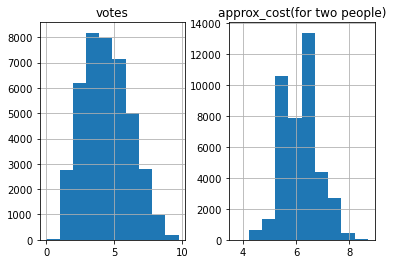

In [185]:
f.transform(df[num])

In [182]:
class sklearnTransformerWrapper(BaseEstimator, TransformerMixin):

    def __init__(self, variable=None, transformer=None):

        if not isinstance(variable, list):
            self.variable = [variable]
        else:
            self.variable = variable

        self.transformer = transformer

    def fit(self, X, y=None):

        self.transformer.fit(X[self.variable])
        return self

    def transform(self, X):
        X = X.copy()

        X[self.variable] = self.transformer.transform(X[self.variable])
        return X

In [183]:
p = sklearnTransformerWrapper(variable=num,
                transformer=FunctionTransformer(func = lambda x: np.log(x+1)))
p.fit(df)
                             

sklearnTransformerWrapper(transformer=FunctionTransformer(func=<function <lambda> at 0x7fb1ad5921f0>),
                          variable=['votes', 'approx_cost(for two people)'])

In [186]:
from sklearn.preprocessing import StandardScaler


In [187]:
scale = sklearnTransformerWrapper(variable=num, transformer=StandardScaler())
scale.fit_transform(df)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city)
0,Jalsa,1,1,4.1,0.477644,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",0.421747,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari
1,Spice Elephant,1,0,4.1,0.491216,Banashankari,Casual Dining,"Chinese, North Indian, Thai",0.421747,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari
2,San Churro Cafe,1,0,3.8,0.639378,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",0.421747,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari
3,Addhuri Udupi Bhojana,0,0,3.7,-0.299359,Banashankari,Quick Bites,"South Indian, North Indian",-0.653667,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari
4,Grand Village,0,0,3.8,-0.211140,Basavanagudi,Casual Dining,"North Indian, Rajasthani",-0.008418,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...
51709,The Farm House Bar n Grill,0,0,3.7,-0.360433,Whitefield,"Casual Dining, Bar","North Indian, Continental",0.421747,"[('Rated 4.0', 'RATED\n Ambience- Big and spa...",Pubs and bars,Whitefield
51711,Bhagini,0,0,2.5,-0.307276,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",0.421747,"[('Rated 4.0', 'RATED\n A fine place to chill...",Pubs and bars,Whitefield
51712,Best Brews - Four Points by Sheraton Bengaluru...,0,0,3.6,-0.368350,Whitefield,Bar,Continental,1.927326,"[('Rated 5.0', ""RATED\n Food and service are ...",Pubs and bars,Whitefield
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,0,1,4.3,-0.131970,"ITPL Main Road, Whitefield",Bar,Finger Food,4.078154,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",Pubs and bars,Whitefield


In [8]:
from pipeline import pipe

In [4]:
x = df.iloc[:10]

In [9]:
pipe.fit(x)

Pipeline(steps=[('drop feature', featuresDrop(variables=['location', 'name'])),
                ('functional',
                 sklearnTransformerWrapper(transformer=FunctionTransformer(func=<function <lambda> at 0x7fa56f55db80>),
                                           variable=['votes',
                                                     'approx_cost(for two '
                                                     'people)'])),
                ('scale',
                 sklearnTransformerWrapper(transformer=StandardScaler(),
                                           variable=['votes',
                                                     'approx_cost(for two '
                                                     'people)'])),
                ('onehot',
                 sklearnOne(transformer=OneHotEncoder(sparse=False),
                            variable=['listed_in(type)', 'rest_type',
                                      'listed_in(city)'])),
                ('countVector', sk

In [10]:
pipe.transform(x)

,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type)_Buffet,listed_in(type)_Cafes,rest_type_Cafe,"rest_type_Cafe, Casual Dining",rest_type_Casual Dining,...,try,unlimited,variety,view,visit,visited,wasnt,went,worth,xã
0,1,1,4.1,0.611122,0.824023,1.0,0.0,0.0,0.0,1.0,...,0.093283,0.000000,0.000000,0.000000,0.028317,0.068487,0.000000,0.075758,0.037879,0.719113
1,1,0,4.1,0.621454,0.824023,1.0,0.0,0.0,0.0,1.0,...,0.162182,0.000000,0.049489,0.056567,0.029539,0.000000,0.000000,0.039514,0.000000,0.000000
2,1,0,3.8,0.725002,0.824023,1.0,0.0,0.0,1.0,0.0,...,0.091923,0.000000,0.000000,0.000000,0.083711,0.060740,0.056100,0.022396,0.022396,0.283452
3,0,0,3.7,-0.846958,-2.610829,1.0,0.0,0.0,0.0,0.0,...,0.030700,0.107077,0.202973,0.000000,0.074553,0.056349,0.015613,0.024932,0.049865,0.236665
4,0,0,3.8,-0.423201,-0.184116,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.347146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,0,3.8,-0.058607,-0.184116,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0,0,3.6,-2.389805,0.824023,1.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.151473,0.000000,0.000000,0.000000,0.000000,0.000000
7,1,1,4.6,1.414010,-0.184116,0.0,1.0,0.0,0.0,0.0,...,0.031960,0.185786,0.000000,0.000000,0.019403,0.017598,0.000000,0.000000,0.000000,0.574882
8,1,0,4.0,0.025115,0.356030,0.0,1.0,1.0,0.0,0.0,...,0.134863,0.000000,0.000000,0.111062,0.071642,0.024754,0.068588,0.036509,0.031945,0.144396
9,1,0,4.2,0.321868,-0.488945,0.0,1.0,1.0,0.0,0.0,...,0.119101,0.000000,0.000000,0.000000,0.054231,0.065582,0.000000,0.000000,0.217633,0.459073
